# Reduced Data Exploration

We used UMAP to reduce the dimensionality of the data. Now, we can reasonably cluster and create a classifier for the data

In [34]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import umap
import hdbscan
from collections import Counter
import seaborn as sns
import plotly.express as px 

In [22]:
primary = pd.read_csv('../data/processed/primary_reduction_neighbors_500_components_100.csv', index_col='Unnamed: 0')
primary.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.174407,4.605017,5.700520,4.349964,0.009240,4.443735,4.977513,1.097707,4.923816,5.728352,...,1.977319,6.758616,3.999133,4.044898,4.987543,1.790490,4.197807,6.984423,9.260715,7.174916
1,1.187639,4.608121,5.704485,4.363834,0.024695,4.443859,4.973516,1.105194,4.919911,5.728892,...,1.981181,6.762886,3.999778,4.040472,4.999935,1.792208,4.192843,6.986716,9.258625,7.172100
2,1.179722,4.631567,5.731539,4.270429,0.007747,4.434293,4.971396,1.129670,4.909443,5.748357,...,2.006164,6.765180,4.005325,4.039588,5.014343,1.786922,4.206350,6.986751,9.256733,7.179493
3,1.233760,4.637250,5.735640,4.311743,0.078151,4.433172,4.963012,1.207390,4.900370,5.740662,...,2.000760,6.769579,3.998335,4.026979,4.999375,1.817481,4.194461,6.987063,9.243600,7.164564
4,1.188722,4.624152,5.721036,4.324148,0.035837,4.437555,4.966181,1.132194,4.908939,5.740864,...,1.998834,6.764676,4.001324,4.034964,5.004535,1.799192,4.201400,6.986776,9.252455,7.172283


In [27]:
prim_umap = pd.read_csv('../data/processed/primary_reduction_neighbors_500_components_2.csv')

In [28]:
prim_umap.head()

,0,1
0,5.046096,6.051372
1,5.173307,6.025374
2,5.373339,5.822965
3,4.976385,5.943276
4,5.092712,5.976449


Now let's run clustering on the cells

In [40]:
clusterer = hdbscan.HDBSCAN(core_dist_n_jobs=1)
clusters = clusterer.fit(primary)

In [41]:
primary['label'] = clusters.labels_

In [42]:
prim_umap['label'] = clusters.labels_

In [43]:
prim_umap.columns

Index(['0', '1', 'label'], dtype='object')

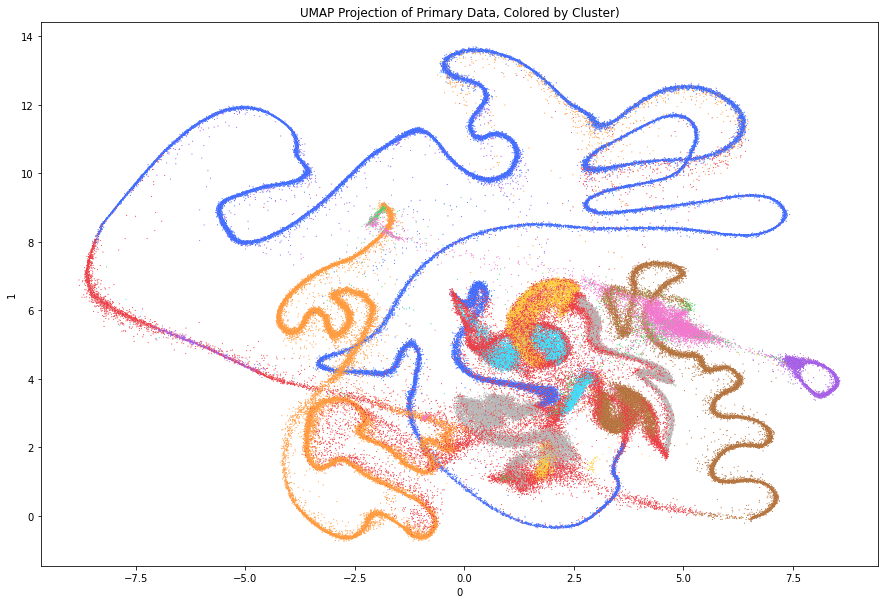

{1: 1280,
 5: 6191,
 25: 224,
 24: 531,
 4: 13725,
 2: 31098,
 3: 5831,
 -1: 103,
 7: 2713,
 27: 110,
 21: 248,
 8: 2724,
 30: 910,
 26: 11,
 6: 14089,
 19: 7232,
 20: 19,
 18: 9046,
 28: 10,
 17: 6108,
 14: 8689,
 16: 5970,
 15: 224,
 9: 42155,
 22: 1083,
 29: 45,
 0: 1302,
 31: 16,
 23: 1206,
 12: 395,
 13: 502,
 10: 25606,
 11: 13}

In [44]:
def two_plot(data):
    fig, ax = plt.subplots(figsize=(15, 10))

    sns.scatterplot(
        x='0', 
        y='1',
        data=data,
        hue='label',
        legend=None,
        ax=ax,
        s=1,
        palette='bright'
    )

    plt.title(f'UMAP Projection of Primary Data, Colored by Cluster)')
    plt.savefig('umap_cluster.png', dpi=300)
    plt.show()

def three_plot(data):
    fig = px.scatter_3d(data, x='0', y='1', z='2', color='label')
    fig.update_layout(marker=dict(size=1))
    fig.show()
    
two_plot(prim_umap)
dict(zip(Counter(clusters.labels_).keys(), Counter(clusters.labels_).values()))

In [50]:
prim_umap.to_csv('primary_labels_test.csv', index=False)

## Classification

Now that we have cell clusters, we can build a classifier on the full space of data to learn the mapping between gene expression and cluster.

Ultimately, we'll have to incorporate two more things in our final model's pipeline:
1. Removing inter-experiment variability  
2. "Normalizing" for cell stress

In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

class GeneClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=100, out_features=16)
        self.fc2 = nn.Linear(in_features=16, out_features=12)
        self.fc3 = nn.Linear(in_features=12, out_features=12)
        self.output = nn.Linear(in_features=12, out_features=primary['label'].nunique())
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.output(x)
        return x


Now that we've defined a basic fully connected neural network, let's split our data into training and testing sets, then use K-fold CV to tune the architecture of our model

In [114]:
X = primary.drop('label', axis=1).values
y = [x+1 for x in primary['label'].values] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

Great, now we can define our loss function, optimization algorithmn and a model instance and get to work!

In [118]:
model = GeneClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model

GeneClassifier(
  (fc1): Linear(in_features=100, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=12, bias=True)
  (fc3): Linear(in_features=12, out_features=12, bias=True)
  (output): Linear(in_features=12, out_features=33, bias=True)
)

Finally, we can train our model and view the accuracy on the test set.

In [121]:
epochs = 100
loss_arr = []

for i in range(epochs):
    y_hat = model.forward(X_train)
    loss = criterion(y_hat, y_train)
    loss_arr.append(loss)

    if i % 10 == 0:
        print(f'Epoch: {i} Loss: {loss}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0 Loss: 0.9663005471229553
Epoch: 10 Loss: 0.9531857371330261
Epoch: 20 Loss: 0.9473836421966553
Epoch: 30 Loss: 0.9538196921348572
Epoch: 40 Loss: 0.9603025317192078
Epoch: 50 Loss: 0.934006929397583
Epoch: 60 Loss: 0.9736332893371582
Epoch: 70 Loss: 1.4917048215866089
Epoch: 80 Loss: 1.0187768936157227
Epoch: 90 Loss: 1.053627371788025
